## Tarea 2 - Machine Learning I
El objetivo es diseñar una red neuronal que sea capaz de predecir el valor de la precipitación mediante la información de variables de larga escala. El dataset consiste en 450 predictores y un predictando, la precipitación en Madrid.
Hay que tener en cuenta que la precipitación es una variable mixta, ya que habrá días con un valor exacto de 0 y otros que se encuentren en el intervalo (0,inf).
Así pues, diseñar una red neuronal con KERAS, que sea capaz de predecir la precipitación de acuerdo con los siguientes índices:
- La ocurrencia de precipitación se evalúa con el AUC. 
- La cantidad de precipitación se evalúa con el MSE.

Podréis valeros de todas las técnicas aprendidas hasta ahora: early stopping, regularización, backpropagation + momento, ajustar el learning rate, poner varias capas y demás. Esto no quiere decir que la red que contenga toda esta variedad de técnicas será la que obtenga un menor error. Tenéis que jugar y probar distintos diseños de redes con el fin de encontrar la que consideréis que obtendría un menor error en un dataset distinto (es decir, que tenga buena capacidad de generalización).

Construiréis vuestro modelo usando xTrain e yTrain, y después evaluaréis el modelo en xTest. La predicción que resulte al evaluar el modelo en xTest es lo que tenéis que guardar en un fichero y lo que se envía para corrección: yTest.to_csv(“1erApellido_Nombre.csv”)
e.g., yTest.to_csv(“Diez_Javier.csv”)

El resultado de ocurrencia deberá ser en formato binario (1-día lluvioso y 0-día no lluvioso) y con la misma logitud que de xTest.

El resultado de cantidad deberá contener ceros para los días no lluvioso y un valor continuo entre 0 e infinito para los días lluviosos. El resultado tendrá la misma logitud que XTest.


**NOTA: se considera día de lluvia si el valor de precipitación es mayor que 1, sino convertir a 0.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import keras
from keras import layers
import random
from tensorflow.keras import regularizers

In [2]:
xtrain = pd.read_csv('Madrid_Alumno_xTrain.csv', index_col = 0).values
ytrain = pd.read_csv('Madrid_Alumno_yTrain.csv', index_col = 0).values
xtest = pd.read_csv('Madrid_Alumno_xTest.csv', index_col = 0).values

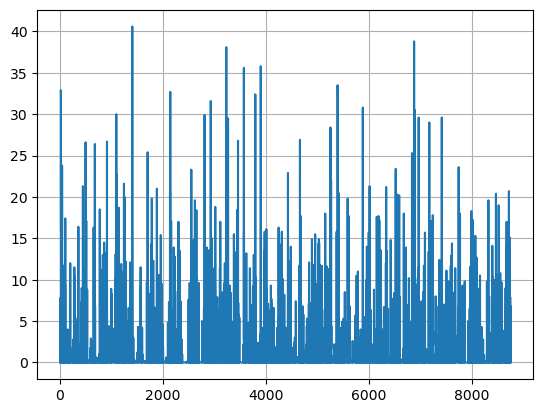

In [3]:
plt.plot(np.arange(len(ytrain)), ytrain)
plt.grid(True)

In [4]:
#preprocesado de los datos
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain) 
xtest = scaler.transform(xtest)

In [5]:
ytrain_occ = np.where(ytrain > 1, 1, 0)

In [6]:
ytrain_cant = ytrain.copy()
ytrain_cant[ytrain<1] = 0

In [7]:
#extraccion del conjunto de validacion para el entrenamiento de las redes
n = len(ytrain)
ntrain2 = int(0.8*n)
indtrain2 = random.sample(range(n), ntrain2)
indval = np.setdiff1d(range(n),indtrain2)

xval = xtrain[indval]
xtrain2 = xtrain[indtrain2]

yval_occ = ytrain_occ[indval]
ytrain2_occ = ytrain_occ[indtrain2]
yval_cant = ytrain_cant[indval]
ytrain2_cant = ytrain_cant[indtrain2]

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True) 

In [9]:
nep = 100 #num epochs

### GridSearch para ocurrencia

In [34]:
def create_model_occ(algoritmo, learning_rate, num_layer, size_layer, reg_lambda, mom,
                     activacion_salida, activacion_hidden, bnorm):
    #estructura red
    model = keras.Sequential()

    model.add(layers.Input(shape=(450,)))
    for i in range(num_layer):
        model.add(layers.Dense(size_layer, activation=activacion_hidden, kernel_regularizer = regularizers.L1(reg_lambda)))
        if bnorm:
            model.add(layers.BatchNormalization())
       
    model.add(layers.Dense(1, activation=activacion_salida, kernel_regularizer = regularizers.L1(reg_lambda)))

    #optimizador
    if algoritmo == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif algoritmo == 'sgd':
        opt = SGD(learning_rate=learning_rate,momentum = mom)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [35]:
#optimizacion de parametros con cross-validacion
#grid de parametros
param = {
    'algoritmo': ['sgd','adam'],
    'learning_rate': [0.01, 0.1],
    'num_layer': [2,4],
    'size_layer':[10,50],
    'reg_lambda':[0.0001,0.01], 
    'mom':[0.9], 
    'activacion_salida':['sigmoid'],
    'activacion_hidden':['relu'],
    'bnorm':[1,0]
}
param_combinations = list(itertools.product(*param.values()))

best_accuracy = 0
best_param = {}

for combination in param_combinations:

    #asignamos el numero de neuronas para cada capa dada
    param_dict = dict(zip(param.keys(), combination))
    
    #compilamos y entrenamos el modelo
    model_occ = create_model_occ(**param_dict)

    history_occ = model_occ.fit(xtrain2, ytrain2_occ, epochs=nep, batch_size=100,
                                verbose=0, validation_data = (xval,yval_occ), callbacks = early_stopping)

    # Evaluar el modelo en el conjunto de prueba
    m_eval = model_occ.evaluate(xval, yval_occ, batch_size=100)    
    accuracy = m_eval[1]

    # Actualizar el mejor modelo y los mejores parámetros si se obtiene un mejor rendimiento
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_param = param_dict
            
# Mostrar los mejores parámetros encontrados y la mejor precisión
print("Mejor combinación de parámetros encontrada: ", best_param)
print("Mejor precisión en el conjunto de prueba: ", best_accuracy)

18/18 [==============================] - 0s 2ms/step - loss: 3.6692 - accuracy: 0.8546
Mejor combinación de parámetros encontrada:  {'algoritmo': 'adam', 'learning_rate': 0.01, 'num_layer': 4, 'size_layer': 50, 'reg_lambda': 0.0001, 'mom': 0.9, 'activacion_salida': 'sigmoid', 'activacion_hidden': 'relu', 'bnorm': 1}
Mejor precisión en el conjunto de prueba:  0.9093500375747681


In [46]:
best_param

{'algoritmo': 'adam',
 'learning_rate': 0.01,
 'num_layer': 4,
 'size_layer': 50,
 'reg_lambda': 0.0001,
 'mom': 0.9,
 'activacion_salida': 'sigmoid',
 'activacion_hidden': 'relu',
 'bnorm': 1}

In [47]:
best_accuracy

0.9093500375747681

### GridSearch para cantidad

In [38]:
def create_model_cant(algoritmo, learning_rate, num_layer, size_layer, reg_lambda, mom,
                     activacion_salida, activacion_hidden, bnorm):
    #estructura red
    model = keras.Sequential()

    model.add(layers.Input(shape=(450,)))
    for i in range(num_layer):
        model.add(layers.Dense(size_layer, activation=activacion_hidden, kernel_regularizer = regularizers.L1(reg_lambda)))
        if bnorm:
            model.add(layers.BatchNormalization())
       
    model.add(layers.Dense(1, activation=activacion_salida, kernel_regularizer = regularizers.L1(reg_lambda)))

    #optimizador
    if algoritmo == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif algoritmo == 'sgd':
        opt = SGD(learning_rate=learning_rate,momentum = mom)

    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])
    return model

In [40]:
#optimizacion de parametros con cross-validacion
#grid de parametros
param = {
    'algoritmo': ['sgd','adam'],
    'learning_rate': [0.01, 0.1],
    'num_layer': [2,4],
    'size_layer':[10,50],
    'reg_lambda':[0.0001,0.01], 
    'mom':[0.9], 
    'activacion_salida':['relu'],
    'activacion_hidden':['relu','sigmoid'],
    'bnorm':[1,0]
}
param_combinations = list(itertools.product(*param.values()))

best_loss = 1e10
best_param2 = {}

for combination in param_combinations:

    #asignamos el numero de neuronas para cada capa dada
    param_dict = dict(zip(param.keys(), combination))
    
    #compilamos y entrenamos el modelo
    model_cant = create_model_cant(**param_dict)

    history_cant = model_cant.fit(xtrain2, ytrain2_cant, epochs=nep, batch_size=100,
                                verbose=0, validation_data = (xval,yval_cant), callbacks = early_stopping)

    # Evaluar el modelo en el conjunto de prueba
    m_eval = model_cant.evaluate(xval, yval_cant, batch_size=100)    
    val_loss = m_eval[1]

    # Actualizar el mejor modelo y los mejores parámetros si se obtiene un mejor rendimiento
    if val_loss < best_loss:
        best_loss = val_loss
        best_param2 = param_dict
            
# Mostrar los mejores parámetros encontrados y la mejor precisión
print("Mejor combinación de parámetros encontrada: ", best_param2)
print("Mejor precisión en el conjunto de prueba: ", best_loss)

18/18 [==============================] - 0s 2ms/step - loss: 13.8108 - mse: 10.7857
Mejor combinación de parámetros encontrada:  {'algoritmo': 'adam', 'learning_rate': 0.01, 'num_layer': 2, 'size_layer': 50, 'reg_lambda': 0.0001, 'mom': 0.9, 'activacion_salida': 'relu', 'activacion_hidden': 'relu', 'bnorm': 1}
Mejor precisión en el conjunto de prueba:  6.276821136474609


In [48]:
best_param2

{'algoritmo': 'adam',
 'learning_rate': 0.01,
 'num_layer': 2,
 'size_layer': 50,
 'reg_lambda': 0.0001,
 'mom': 0.9,
 'activacion_salida': 'relu',
 'activacion_hidden': 'relu',
 'bnorm': 1}

In [49]:
best_loss

6.276821136474609

### Predicciones sobre test

##### Ocurrencia

In [51]:
#diseño modelo optimo
model_occ = create_model_occ(**best_param)

In [66]:
#entreno modelo optimo
random.seed(2)
history = model_occ.fit(xtrain2, ytrain2_occ, epochs=nep, batch_size=100, 
              verbose=0, validation_data = (xval,yval_occ), callbacks = early_stopping)

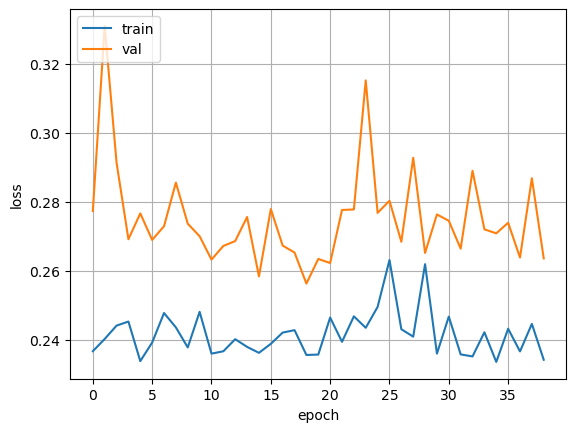

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)

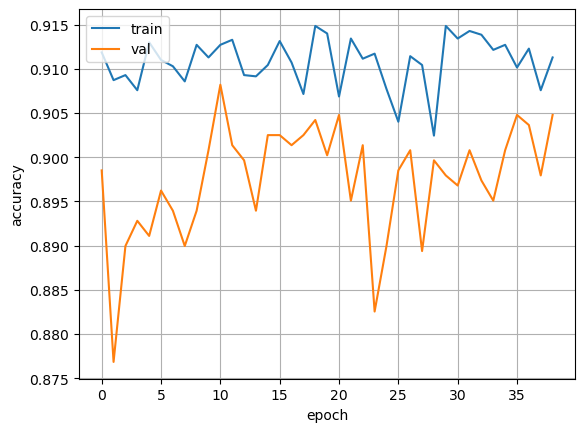

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)

In [72]:
#prediccion
ypred_occ = model_occ.predict(xtest)

69/69 [==============================] - 0s 2ms/step


In [73]:
ypred_occ = np.where(ypred_occ < 0.5,0,1)

##### Cantidad

In [75]:
#diseño modelo optimo
model_cant = create_model_cant(**best_param2)

In [76]:
#entreno modelo optimo
random.seed(0)
history2 = model_cant.fit(xtrain2, ytrain2_cant, epochs=nep, batch_size=100, 
              verbose=0, validation_data = (xval,yval_cant), callbacks = early_stopping)

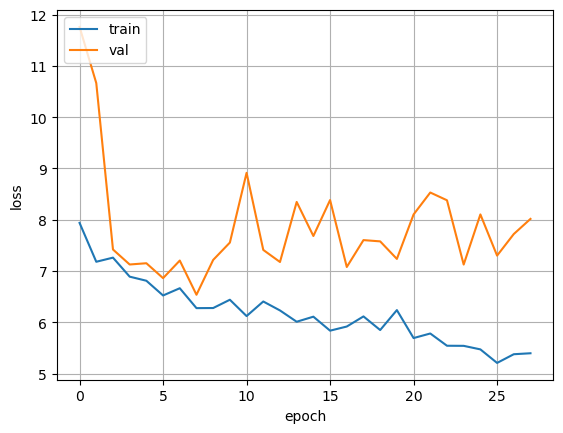

In [77]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)

In [85]:
#pruebo en conjunto val
ypred_cant = model_cant.predict(xtest)

69/69 [==============================] - 0s 2ms/step


In [86]:
ypred_cant[ypred_cant <1] = 0

Además deberéis de responder a las siguiente cuestiones:

1- ¿Cómo has preprocesado los datos y por qué (por ejemplo, has estandarizado el predictando o los predictores)? **Descríbe** el proceso en 3-4 líneas.

He procesado el predictando para que se ajuste al formato correspondiente a cada problema: discretizado para la clasificación y para la predicción en cantidades, llevados a cero los valores menores a uno. Por otro lado, en cuanto a los predictores, los he estandarizado para evitar diferencias grandes en el orden de magnitud de cada uno.

2- ¿Qué topología de red neuronal has encontrado óptima para la **ocurrencia de precipitación**? **Describe** en 3-4 líneas por qué has usado esta topología e incluye el **código de Keras**

Para la ocurrencia de precipitación, la configuración óptima ha sido cuatro capas ocultas de 50 neuronas cada una. Esta topología se ha elegido a través de una búsqueda sobre un grid de parámetros del modelo, se ha evaluado el accuracy sobre una muestra de validación para cada combinación de parámetros, y se ha escogido la combinación que maximiza la métrica.

3- ¿Qué topología de red neuronal has encontrado óptima para la **cantidad de precipitación**? **Describe** en 3-4 líneas por qué has usado esta topología e incluye el **código de Keras**

Para la cantidad de precipitación, la configuración óptima ha sido dos capas ocultas de 50 neuronas cada una. Esta topología se ha elegido cross-validando sobre un grid de parámetros de la misma forma que para la cantidad de precipitación, siendo la única diferencia que se ha minimizado el mse en vez de maximizado el accuracy.

### Guardar resultados
Ejemplo de cómo deben guardarse los resultados

In [7]:
# ocurrencia = np.array([0, 0, 0, 1, 1, 0, 0, 0])
# cantidad = np.array([0, 0, 0, 16, 12.5, 0, 0, 0])

In [90]:
yTest = pd.DataFrame(index = np.arange(len(ypred_occ)))
yTest['ocurrencia'] = ypred_occ
yTest['cantidad'] = ypred_cant
yTest.to_csv('Madueno_Miguel.csv')